In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from glob import glob

In [2]:
img_folders_cleand = ['MotorBike', 'Car', 'Bike', 'Person']
cls_to_idx = {i:j for j,i in enumerate(img_folders_cleand)}
idx_to_cls = {i:j for j,i in cls_to_idx.items()}

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


num_classes = len(cls_to_idx)
# num_classes = 4

class ThreeHeadNetwork(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ThreeHeadNetwork, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        self.basemodel = nn.Sequential(nn.Conv2d(3, 64, (9,9), stride=2, padding=4),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.MaxPool2d((3,3), stride=2, padding=1),

                                       nn.Conv2d(64, 256, (7,7), stride=2, padding=3),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.MaxPool2d((3,3), stride=2, padding=1),

                                       nn.Conv2d(256, 256, (5,5), stride=2, padding=2),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),

                                       nn.Conv2d(256, 512, (5,5), stride=1, padding=0),)

        self.objectness_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.3),
                                             nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                             nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                             nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                             nn.Conv2d(32, 1, (1,1), stride=1, padding=0), nn.Sigmoid())

        self.bbox_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.3),
                                        nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                        nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                        nn.Conv2d(32, 4, (1,1), stride=1, padding=0), nn.Sigmoid())

        self.class_head = nn.Sequential(nn.Conv2d(512, 256, (1,1), stride=1, padding=0), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(256, 128, (1,1), stride=1, padding=0), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
                                        nn.Conv2d(128, 64, (1,1), stride=1, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
                                        nn.Conv2d(64, 32, (1,1), stride=1, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
                                        nn.Conv2d(32, self.num_classes, (1,1), stride=1, padding=0))

    def forward(self, x):
        features = self.basemodel(x)

        objectness_out = self.objectness_head(features)
        class_out = self.class_head(features)
        bbox_out = self.bbox_head(features)

        return objectness_out, class_out, bbox_out

In [4]:
w, h = (129,129)
strides = 32

## minimun input that gives (1 x 1) is (129 x 129)
## maximun input that gives (1 x 1) is (160 x 160)
## input of (161 x 161) gives (2 x 2)
## so, (65+N*31, 65+N*31) gives (NxN)
## so, network has strides of 32

model = torch.load('threeHeadMob_entire.pt',
                    weights_only=False, map_location=torch.device('cpu'))
model = model.eval()

In [5]:
tensor_transform = transforms.ToTensor()
img_path = glob('Test/*.jpg')[2]
cv2_image = cv2.imread(img_path)
cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
tensor_image = tensor_transform(cv2_image)

output = model(tensor_image.unsqueeze(0))
obj, lbl, bbox = list(map(lambda x: x.squeeze(0), output))

colums, rows = obj.shape[1:]
obj.shape, lbl.shape, bbox.shape

(torch.Size([1, 18, 28]), torch.Size([4, 18, 28]), torch.Size([4, 18, 28]))

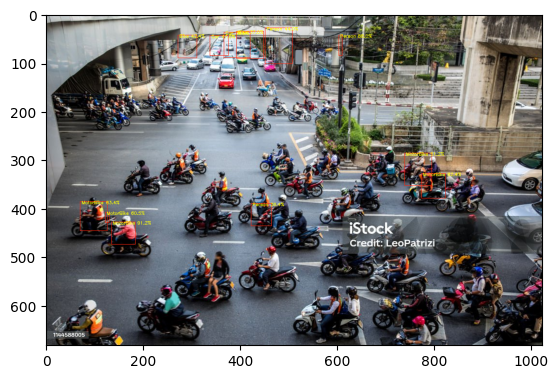

In [6]:
def add_to_image(image, total_bboxes, total_texts):
    for bbox, text in zip(total_bboxes, total_texts):
        image = cv2.rectangle(image, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,36,12), 1)
        image = cv2.putText(image, text, (bbox[0]+3, bbox[1]+5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,0), 1)
    return image

softmax = nn.Softmax(dim=0)

image = cv2_image.copy()

total_bboxes = []
total_texts = []
for i in range(colums):
    for j in range(rows):
        
        obj_pred = obj[:, i,j]
        label_pred = lbl[:, i,j]
        bbox_pred = bbox[:, i,j]
        
        if obj_pred>0.5:
            
            max_idx = torch.argmax(label_pred, dim=0).item()
            class_name = idx_to_cls[max_idx]
            acc = (softmax(label_pred)[max_idx]).item()*100
            text = f'{class_name} {acc:.1f}%'
            total_texts.append(text)

            bbox_pred = [int((bbox_pred[idx]*h)+(i*strides)) if idx in [1, 3] else int((bbox_pred[idx]*w)+(j*strides)) for idx in range(len(bbox_pred))]
            total_bboxes.append(bbox_pred)


image = add_to_image(image, total_bboxes, total_texts)
plt.imshow(image)
plt.show()

In [7]:
## Next is Yolo object detection algorithm